# **Image Classification CNN - Alen Abdrakhamnov**

###1. The first task is to create a DataLoader for the training & testing datasets, which should generate batches of examples

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F



transform ensures the PyTorch tensor is of correct shape (Channel, Height, Width), and scales values [-1,1]

Loading the CIFAR-10 datasets:


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# train dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# testing dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Fetching a batch of data from the training loader and printing the shape:

The below was also done for test loader, to ensure the tensor shapes are equivalent

In [ ]:
for images, labels in train_loader:
    print(images.shape)  # (batch_size, 3, 32, 32)
    print(labels.shape)  # (batch_size,)
    break


torch.Size([128, 3, 32, 32])
torch.Size([128])


Creating DataLoaders:

| Tensor | Shape           | Meaning                                                                          |
|--------|-----------------|----------------------------------------------------------------------------------|
| images | [128, 3, 32, 32] | 128 images, each with 3 channels (RGB), 32×32 pixels                              |
| labels | [128]           | 128 integer labels (one for each image), values from 0–9 (CIFAR-10 classes)        |


Setting up intermediate block:

In [ ]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs, kernel_size=3):
        super().__init__()
        self.num_convs = num_convs


        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2),
                nn.BatchNorm2d(out_channels),  # Added BatchNorm and ReLU
                nn.ReLU()
            ) for _ in range(num_convs)
        ])


        self.weight_fc = nn.Linear(in_channels, num_convs) #fully connected layer
        self.softmax = nn.Softmax(dim=1)  # softmax activation

    def forward(self, x):
        batch_size = x.size(0)


        conv_outputs = [conv(x) for conv in self.convs]


        m = x.mean(dim=[2, 3])  # channel wise input

        a = self.weight_fc(m)  # fc to produce weights
        a = self.softmax(a)    # softmax to get normalized weights

        # Weighted sum of convolution outputs
        a = a.view(batch_size, self.num_convs, 1, 1, 1)
        stacked = torch.stack(conv_outputs, dim=1)
        x_out = (a * stacked).sum(dim=1)

        return x_out

Output Block:

In [ ]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, hidden_dim=0, num_classes=10):
        super().__init__()

        if hidden_dim > 0:
            self.block = nn.Sequential(
                nn.Linear(in_channels, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, num_classes)
            )
        else:
            self.block = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        m = x.mean(dim=[2, 3])
        return self.block(m)


Complete Architecture:

In [ ]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, in_channels=3, num_blocks=7, num_convs_per_block=7,
                 base_channels=32, num_classes=64, hidden_dim=64):
        super().__init__()
        self.blocks = nn.ModuleList()
        c_in = in_channels

        channels = [base_channels for _ in range(num_blocks)] # constant channels

        for i in range(num_blocks):
            block = IntermediateBlock(
                in_channels=c_in,
                out_channels=channels[i],
                num_convs=num_convs_per_block
            )
            self.blocks.append(block)
            c_in = channels[i]  # constant channel count for next block

        self.output_block = OutputBlock(
            in_channels=channels[-1],
            hidden_dim=hidden_dim,
            num_classes=num_classes
        )

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return self.output_block(x)


Now we're ready to train the neural network. I'm using corss entropy loss for training:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# enable cuda for faster gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# modified architecture parameters:
# 7 intermediate blocks instead of 3
#  7 convolutional layers per block instead of 3
#  Constant 64 channels for all blocks
model = CustomCNN(
    in_channels=3,
    num_blocks=7,
    num_convs_per_block=7,
    base_channels=64,
    num_classes=10,
    hidden_dim=64
).to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0007, weight_decay=1e-4)

# scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

#parameters
num_epochs = 200
train_losses = []              # Average loss per epoch
test_losses = []               # Average test loss per epoch
train_batch_losses = []        # List of lists: each inner list contains losses for each training batch in that epoch
train_accuracies = []          # Training accuracy per epoch
test_accuracies = []           # testing accuracy per epoch

# Early stopping
patience = 10
best_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_batch_losses = []

    # Training over batches
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()          # backpropagation
        optimizer.step()         # Update weights

        batch_loss = loss.item()
        running_loss += batch_loss             # accumulate loss for the epoch
        epoch_batch_losses.append(batch_loss)  # store this batch loss

        # Print the loss for training batch
        print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {batch_loss:.4f}")


    train_batch_losses.append(epoch_batch_losses)


    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    scheduler.step()

    # evaluation - train
    model.eval()
    train_correct, train_total = 0, 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
    train_acc = 100 * train_correct / train_total
    train_accuracies.append(train_acc)

    # evaluation - test
    test_correct, test_total = 0, 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_acc = 100 * test_correct / test_total
    test_accuracies.append(test_acc)

    # epoch-level statistics
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.4f} - Test Loss: {avg_test_loss:.4f} - Train Acc: {train_acc:.2f}% - Test Acc: {test_acc:.2f}%")

    # Early Stoppinng
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved new best model with test loss: {avg_test_loss:.4f}")
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered. No improvement in test loss for", patience, "epochs.")
        break


Streaming output truncated to the last 5000 lines.
Epoch [23/200] Batch [99/391] Loss: 0.2814
Epoch [23/200] Batch [100/391] Loss: 0.1888
Epoch [23/200] Batch [101/391] Loss: 0.1563
Epoch [23/200] Batch [102/391] Loss: 0.1676
Epoch [23/200] Batch [103/391] Loss: 0.2100
Epoch [23/200] Batch [104/391] Loss: 0.2578
Epoch [23/200] Batch [105/391] Loss: 0.1293
Epoch [23/200] Batch [106/391] Loss: 0.1639
Epoch [23/200] Batch [107/391] Loss: 0.2172
Epoch [23/200] Batch [108/391] Loss: 0.1863
Epoch [23/200] Batch [109/391] Loss: 0.1795
Epoch [23/200] Batch [110/391] Loss: 0.2208
Epoch [23/200] Batch [111/391] Loss: 0.2806
Epoch [23/200] Batch [112/391] Loss: 0.0923
Epoch [23/200] Batch [113/391] Loss: 0.1734
Epoch [23/200] Batch [114/391] Loss: 0.1485
Epoch [23/200] Batch [115/391] Loss: 0.1425
Epoch [23/200] Batch [116/391] Loss: 0.1882
Epoch [23/200] Batch [117/391] Loss: 0.1892
Epoch [23/200] Batch [118/391] Loss: 0.1605
Epoch [23/200] Batch [119/391] Loss: 0.1489
Epoch [23/200] Batch [120/

In [ ]:
torch.save(model.state_dict(), 'custom_cnn.pth')


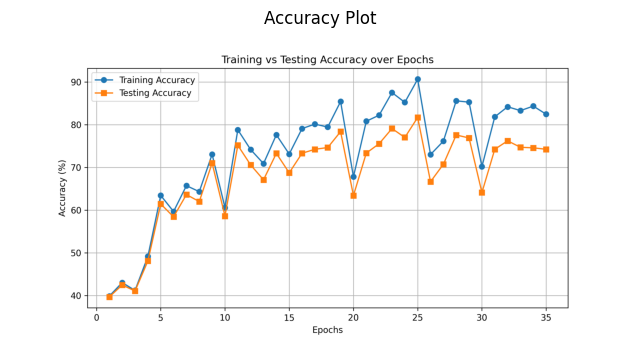

In [ ]:
import matplotlib.pyplot as plt
#accuracy per epoch for train & test sets
epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# training loss per batch for each epoch
plt.figure(figsize=(12, 8))

for epoch_idx, batch_losses in enumerate(train_batch_losses):
    batch_indices = np.arange(1, len(batch_losses) + 1)
    plt.plot(batch_indices, batch_losses, label=f"Epoch {epoch_idx + 1}")

plt.xlabel("Batch Number")
plt.ylabel("Training Loss")
plt.title("Training Loss per Batch Across Epochs")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize='small')
plt.grid(True)

# Save the figure
plt.savefig("train_loss_per_batch_per_epoch.png", bbox_inches='tight', dpi=300)
plt.show()
